In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math

In [3]:
api = wandb.Api(timeout=19)

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

In [6]:
brightness_factor = 0.75
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": brightness_factor,"config.homeostasis": 0, "config.normtype": 0,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": brightness_factor,"config.homeostasis": 0, "config.normtype": 1,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")

In [7]:
EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch', filters={"config.dataset": "fashionmnist", 
                                                                        "config.homeostasis": 1, "config.normtype": 0,
                                                                        "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                        "config.homeostatic_annealing": 0 ,  "config.implicit_homeostatic_loss": 1}, order="-summary_metrics.test_acc")

In [8]:
len(EI)

198

/tmp/ipykernel_1825315/3984606999.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(rn.config['lambda_homeo'], rn.config['lambda_homeo_var'], color=cmap(values[int(rn.summary['test_acc'])]), vmin=70, vmax=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


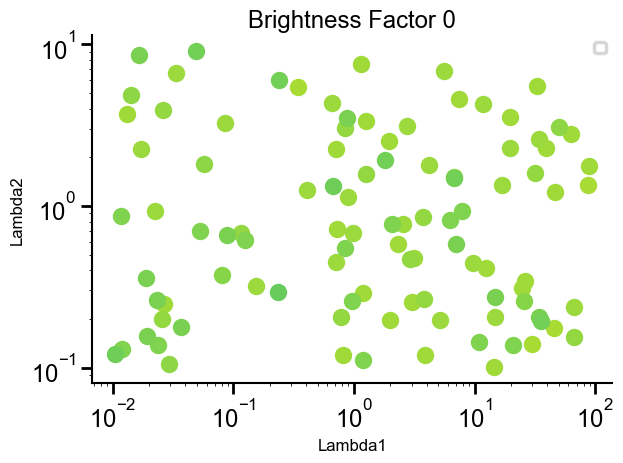

In [31]:

fig, ax = plt.subplots()
cmap = plt.get_cmap('viridis')

values = np.linspace(0, 1, 100)
#values = np.logspace(0, 1, num=100)/max(np.logspace(0, 1, num=100))

EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": brightness_factor,"config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                    "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 1 }, order="-summary_metrics.test_acc")

data = []

activate_color = True

for idxx, rn in enumerate(EI):
    plt.scatter(rn.config['lambda_homeo'], rn.config['lambda_homeo_var'], color=cmap(values[int(rn.summary['test_acc'])]), vmin=70, vmax=90)
    activate_color = False



ax.set_xlabel("Lambda1")
ax.set_ylabel("Lambda2")
ax.legend(fontsize=10)
ax.set_title(f'Brightness Factor {brightness_factor}')
ax.set_xscale('log')
ax.set_yscale('log')

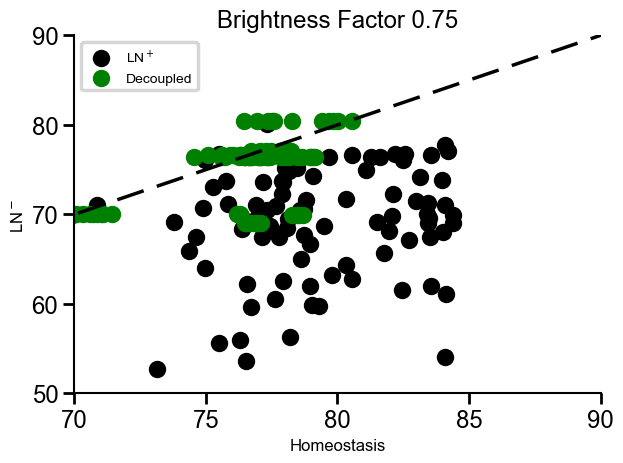

In [41]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])
# print(f"Here: {top_n}")

activate_color = True

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black", label="LN$^+$" if activate_color else None)
            activate_color = False


EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": brightness_factor,"config.homeostasis": 1, "config.normtype": 0,
                                                                "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 1 }, order="-summary_metrics.test_acc")
# print(len(EI))

data = []

activate_color = True

best_LN_plus = []
best_LN_minus = []

EI_lambdas = {}

failed_runs = 0

for top in range(top_n):
    best_acc_run_ln_config = 0

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    best_LN_minus.append(vanilla_dann_acc)
    EI_lambdas_temp = {}

    for rn in EI:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="green", label=f"Decoupled" if activate_color else None)
            activate_color = False



ax.set_xlabel(f"Homeostasis")
ax.set_ylabel("LN$^-$")
ax.legend(fontsize=10)
ax.set_title(f'Brightness Factor {brightness_factor}')
list_line = range(100)
ax.set_xlim(70, 90)
ax.set_ylim(50, 90)
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')

YES


/tmp/ipykernel_3486659/4045554678.py:72: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmax' will be ignored
  plt.scatter(rn.config['lambda_homeo'], rn.config['lambda_homeo_var'], color=cmap(values[color_map_val]), label=f"Decoupled" if activate_color else None, vmax=100)


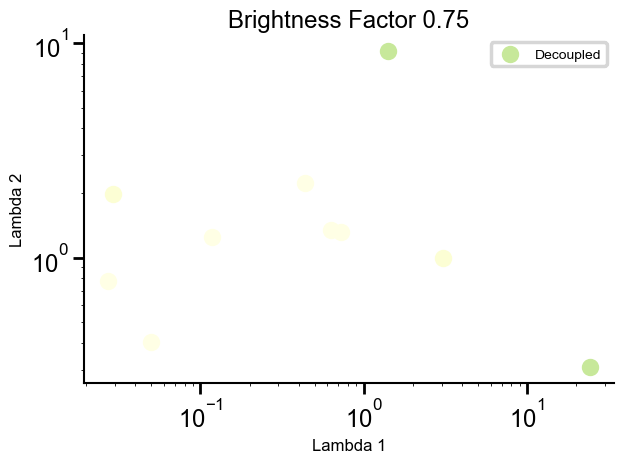

In [36]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('YlGn')

values = np.linspace(0, 1, 200)


top_n = len(runs_dict["runs_vanilla_dann"])
# print(f"Here: {top_n}")

activate_color = True

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            #plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black", label="LN$^+$" if activate_color else None)
            activate_color = False


EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN_ExhaustiveSearch', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": brightness_factor,"config.homeostasis": 1, "config.normtype": 0,
                                                                "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 1 }, order="-summary_metrics.test_acc")
# print(len(EI))

data = []

activate_color = True

best_LN_plus = []
best_LN_minus = []

EI_lambdas = {}

failed_runs = 0

hparm_idx = 0
hparm_target = 2

for top in range(top_n):
    best_acc_run_ln_config = 0

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    best_LN_minus.append(vanilla_dann_acc)
    EI_lambdas_temp = {}

    getout = False
    count = 0

    for rn in EI:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
            if rn.summary['test_acc']-vanilla_dann_acc < 0:
                continue
            count = count + 1
    
    if count < 9:
        continue
    
    if hparm_idx == hparm_target:
        print("YES")
        for rn in EI:
            if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                getout=True
                if rn.summary['test_acc']-vanilla_dann_acc < 0:
                    continue
                color_map_val = int(rn.summary['test_acc']-vanilla_dann_acc)*10
                
                plt.scatter(rn.config['lambda_homeo'], rn.config['lambda_homeo_var'], color=cmap(values[color_map_val]), label=f"Decoupled" if activate_color else None, vmax=100)
                activate_color = False

    

    hparm_idx = hparm_idx + 1



ax.set_xlabel(f"Lambda 1")
ax.set_ylabel("Lambda 2")
ax.legend(fontsize=10)
ax.set_title(f'Brightness Factor {brightness_factor}')
ax.set_yscale('log')
ax.set_xscale('log')
# list_line = range(100)
# # ax.set_xlim(70, 90)
# # ax.set_ylim(50, 90)
# ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')